In [2]:
# Import the libraries we will need
import pandas as pd
import numpy as np

import findspark
findspark.init()

from pyspark.sql import *
import pyspark.sql.functions as F
from pyspark.sql.types import *

# create the Spark Session
spark = SparkSession.builder.appName("Q2").getOrCreate()

In [3]:
data = spark.read.csv("hw2-bundle/hw2-bundle/kmeans/data/data.txt").toDF("observation")
data = data.withColumn("observation", F.split(F.col("observation"), " ").cast("array<float>"))
data = data.withColumn("obs_index", F.monotonically_increasing_id())
window = Window.orderBy(F.col("obs_index"))
data = data.withColumn("obs_index", F.row_number().over(window) - 1)

init_C_random = spark.read.csv("hw2-bundle/hw2-bundle/kmeans/data/c1.txt").toDF("centroid")
init_C_random = init_C_random.withColumn("centroid", F.split(F.col("centroid"), " ").cast("array<float>"))
init_C_random = init_C_random.withColumn("c_index", F.monotonically_increasing_id())
window = Window.orderBy(F.col("c_index"))
init_C_random = init_C_random.withColumn("c_index", F.row_number().over(window) - 1)

init_C_far = spark.read.csv("hw2-bundle/hw2-bundle/kmeans/data/c2.txt").toDF("centroid")
init_C_far = init_C_far.withColumn("centroid", F.split(F.col("centroid"), " ").cast("array<float>"))
init_C_far = init_C_far.withColumn("c_index", F.monotonically_increasing_id())
window = Window.orderBy(F.col("c_index"))
init_C_far = init_C_far.withColumn("c_index", F.row_number().over(window) - 1)

In [4]:
data.show(5)

+--------------------+---------+
|         observation|obs_index|
+--------------------+---------+
|[0.0, 0.64, 0.64,...|        0|
|[0.21, 0.28, 0.5,...|        1|
|[0.06, 0.0, 0.71,...|        2|
|[0.0, 0.0, 0.0, 0...|        3|
|[0.0, 0.0, 0.0, 0...|        4|
+--------------------+---------+
only showing top 5 rows



In [5]:
init_C_random.show(10)

+--------------------+-------+
|            centroid|c_index|
+--------------------+-------+
|[0.0, 0.64, 0.64,...|      0|
|[0.21, 0.28, 0.5,...|      1|
|[0.06, 0.0, 0.71,...|      2|
|[0.0, 0.0, 0.0, 0...|      3|
|[0.0, 0.0, 0.0, 0...|      4|
|[0.0, 0.0, 0.0, 0...|      5|
|[0.0, 0.0, 0.0, 0...|      6|
|[0.0, 0.0, 0.0, 0...|      7|
|[0.15, 0.0, 0.46,...|      8|
|[0.06, 0.12, 0.77...|      9|
+--------------------+-------+



In [10]:
def k_means(observation, initial_centroids, max_iter):
    def comb(x, y):
        if isinstance(x, list) & isinstance(y, list):
            return x + y
        elif isinstance(x, list):
            return x + [y]
        elif isinstance(y, list):
            return [x] + y
        else:
            return [x] + [y]
    
    def l2_distance(x, y):
        return float(np.linalg.norm(np.array(x) - np.array(y), ord=2) ** 2)
    l2_distance_udf = F.udf(l2_distance, FloatType())

    cost = np.zeros(max_iter + 1)

    # iteration 0 (initialization)
    new_partitions = observation.crossJoin(initial_centroids)
    new_partitions = new_partitions.withColumn("obs_to_c_dist", l2_distance_udf(F.col("observation"), F.col("centroid")))

    window = Window.partitionBy("obs_index")
    new_partitions = new_partitions.withColumn("min_dist", F.min("obs_to_c_dist").over(window))
    new_partitions = new_partitions.filter(((F.col("min_dist") - F.col("obs_to_c_dist")) < 1e-6) &
                                        ((F.col("obs_to_c_dist") - F.col("min_dist")) < 1e-6)).sort("obs_index").drop("min_dist")

    new_centroids = new_partitions.rdd.map(lambda row: (row["c_index"], row["observation"]))
    new_centroids = new_centroids.reduceByKey(lambda x, y: [comb(x[i], y[i]) for i in range(len(x))])
    new_centroids = new_centroids.map(lambda x: x if np.array(x[1]).ndim == 1 else (x[0], np.mean(np.array(x[1]), axis=1).tolist()))
    new_centroids = spark.createDataFrame(new_centroids).toDF("c_index", "centroid")

    cost[0] = np.sum(new_partitions.select("obs_to_c_dist").rdd.flatMap(lambda x: x).collect())
    print(f"At iteration 0, the cost is {cost[0]}.")

    # rest iterations
    for t in np.arange(1, max_iter + 1):
        new_partitions = observation.crossJoin(new_centroids)
        new_partitions = new_partitions.withColumn("obs_to_c_dist", l2_distance_udf(F.col("observation"), F.col("centroid")))

        window = Window.partitionBy("obs_index")
        new_partitions = new_partitions.withColumn("min_dist", F.min("obs_to_c_dist").over(window))
        new_partitions = new_partitions.filter(((F.col("min_dist") - F.col("obs_to_c_dist")) < 1e-6) &
                                            ((F.col("obs_to_c_dist") - F.col("min_dist")) < 1e-6)).sort("obs_index").drop("min_dist")

        new_centroids = new_partitions.rdd.map(lambda row: (row["c_index"], row["observation"]))
        new_centroids = new_centroids.reduceByKey(lambda x, y: [comb(x[i], y[i]) for i in range(len(x))])
        new_centroids = new_centroids.map(lambda x: x if np.array(x[1]).ndim == 1 else (x[0], np.mean(np.array(x[1]), axis=1).tolist()))
        new_centroids = spark.createDataFrame(new_centroids).toDF("c_index", "centroid")
        
        cost[t] = np.sum(new_partitions.select("obs_to_c_dist").rdd.flatMap(lambda x: x).collect())

        print(f"At iteration {t}, the cost is {cost[t]}.")

        new_centroids = new_centroids.collect()
        new_centroids = spark.createDataFrame(data=new_centroids)
    
    return cost, new_centroids.collect()

In [16]:
def k_medians(observation, initial_centroids, max_iter):
    def comb(x, y):
        if isinstance(x, list) & isinstance(y, list):
            return x + y
        elif isinstance(x, list):
            return x + [y]
        elif isinstance(y, list):
            return [x] + y
        else:
            return [x] + [y]
    
    def l1_distance(x, y):
        return float(np.linalg.norm(np.array(x) - np.array(y), ord=1))
    l1_distance_udf = F.udf(l1_distance, FloatType())

    cost = np.zeros(max_iter + 1)

    # iteration 0 (initialization)
    new_partitions = observation.crossJoin(initial_centroids)
    new_partitions = new_partitions.withColumn("obs_to_c_dist", l1_distance_udf(F.col("observation"), F.col("centroid")))

    window = Window.partitionBy("obs_index")
    new_partitions = new_partitions.withColumn("min_dist", F.min("obs_to_c_dist").over(window))
    new_partitions = new_partitions.filter(((F.col("min_dist") - F.col("obs_to_c_dist")) < 1e-6) &
                                        ((F.col("obs_to_c_dist") - F.col("min_dist")) < 1e-6)).sort("obs_index").drop("min_dist")

    new_centroids = new_partitions.rdd.map(lambda row: (row["c_index"], row["observation"]))
    new_centroids = new_centroids.reduceByKey(lambda x, y: [comb(x[i], y[i]) for i in range(len(x))])
    new_centroids = new_centroids.map(lambda x: x if np.array(x[1]).ndim == 1 else (x[0], np.median(np.array(x[1]), axis=1).tolist()))
    new_centroids = spark.createDataFrame(new_centroids).toDF("c_index", "centroid")

    cost[0] = np.sum(new_partitions.select("obs_to_c_dist").rdd.flatMap(lambda x: x).collect())
    print(f"At iteration 0, the cost is {cost[0]}.")

    # rest iterations
    for t in np.arange(1, max_iter + 1):
        new_partitions = observation.crossJoin(new_centroids)
        new_partitions = new_partitions.withColumn("obs_to_c_dist", l1_distance_udf(F.col("observation"), F.col("centroid")))

        window = Window.partitionBy("obs_index")
        new_partitions = new_partitions.withColumn("min_dist", F.min("obs_to_c_dist").over(window))
        new_partitions = new_partitions.filter(((F.col("min_dist") - F.col("obs_to_c_dist")) < 1e-6) &
                                            ((F.col("obs_to_c_dist") - F.col("min_dist")) < 1e-6)).sort("obs_index").drop("min_dist")

        new_centroids = new_partitions.rdd.map(lambda row: (row["c_index"], row["observation"]))
        new_centroids = new_centroids.reduceByKey(lambda x, y: [comb(x[i], y[i]) for i in range(len(x))])
        new_centroids = new_centroids.map(lambda x: x if np.array(x[1]).ndim == 1 else (x[0], np.median(np.array(x[1]), axis=1).tolist()))
        new_centroids = spark.createDataFrame(new_centroids).toDF("c_index", "centroid")

        cost[t] = np.sum(new_partitions.select("obs_to_c_dist").rdd.flatMap(lambda x: x).collect())

        print(f"At iteration {t}, the cost is {cost[t]}.")

        new_centroids = new_centroids.collect()
        new_centroids = spark.createDataFrame(data=new_centroids)
    
    return cost, new_centroids.collect()

In [11]:
random_init_k_means_result = k_means(data, init_C_random, 20)

At iteration 0, the cost is 623747853.501003.
At iteration 1, the cost is 509851314.32013464.
At iteration 2, the cost is 485474452.5887642.
At iteration 3, the cost is 463988316.4755316.
At iteration 4, the cost is 460962508.41108465.
At iteration 5, the cost is 460535298.9382901.
At iteration 6, the cost is 460318803.0705867.
At iteration 7, the cost is 460080311.42658806.
At iteration 8, the cost is 459741193.231719.
At iteration 9, the cost is 459268146.63733053.
At iteration 10, the cost is 458712996.45647573.
At iteration 11, the cost is 458078770.02630186.
At iteration 12, the cost is 457650806.63430023.
At iteration 13, the cost is 457326253.8770542.
At iteration 14, the cost is 457050435.7303591.
At iteration 15, the cost is 456904555.2225838.
At iteration 16, the cost is 456689186.52865505.
At iteration 17, the cost is 456376826.2873359.
At iteration 18, the cost is 456152455.02207327.
At iteration 19, the cost is 455954423.19662714.
At iteration 20, the cost is 455694378.763

In [12]:
far_init_k_means_result = k_means(data, init_C_far, 20)

At iteration 0, the cost is 438747790.54135436.
At iteration 1, the cost is 249803934.05744743.
At iteration 2, the cost is 194494814.57943535.
At iteration 3, the cost is 169804841.52536488.
At iteration 4, the cost is 156295748.97527695.
At iteration 5, the cost is 149094208.22738743.
At iteration 6, the cost is 142508531.39361858.
At iteration 7, the cost is 132303869.35682392.
At iteration 8, the cost is 117170969.81646061.
At iteration 9, the cost is 108547377.13222313.
At iteration 10, the cost is 102237203.3507452.
At iteration 11, the cost is 98278015.55414486.
At iteration 12, the cost is 95630226.12054539.
At iteration 13, the cost is 93793314.01820278.
At iteration 14, the cost is 92377132.14172363.
At iteration 15, the cost is 91541606.04525137.
At iteration 16, the cost is 91045573.80590725.
At iteration 17, the cost is 90752240.03059769.
At iteration 18, the cost is 90470170.25080109.
At iteration 19, the cost is 90216416.34169483.
At iteration 20, the cost is 90162390.98

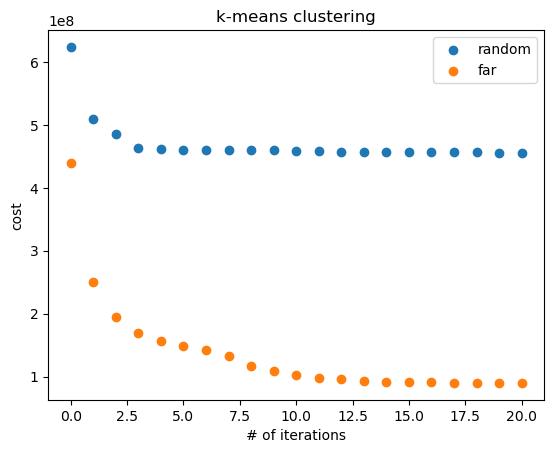

The cost decrease by 0.2645858516678036 after 10 iterations for random initialization
The cost decrease by 0.76697955965864 after 10 iterations for far initialization


In [24]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.scatter(np.arange(0, 21), random_init_k_means_result[0], label="random")
ax.scatter(np.arange(0, 21), far_init_k_means_result[0], label="far")
ax.set_xlabel("# of iterations")
ax.set_ylabel("cost")
ax.set_title("k-means clustering")
ax.legend()
plt.show()

print(f"The cost decrease by {1 - random_init_k_means_result[0][10] / random_init_k_means_result[0][0]} after 10 iterations for random initialization")
print(f"The cost decrease by {1 - far_init_k_means_result[0][10] / far_init_k_means_result[0][0]} after 10 iterations for far initialization")

In [17]:
random_init_k_medians_result = k_medians(data, init_C_random, 20)

At iteration 0, the cost is 566777.1785924435.
At iteration 1, the cost is 425561.92475271225.
At iteration 2, the cost is 415979.95359766483.
At iteration 3, the cost is 414664.6991108656.
At iteration 4, the cost is 413862.83728802204.
At iteration 5, the cost is 412161.43255865574.
At iteration 6, the cost is 410899.23409593105.
At iteration 7, the cost is 409646.5692397356.
At iteration 8, the cost is 408404.7722004652.
At iteration 9, the cost is 407853.52526938915.
At iteration 10, the cost is 407554.51330935955.
At iteration 11, the cost is 407017.7798475027.
At iteration 12, the cost is 406552.0641564131.
At iteration 13, the cost is 406377.47324740887.
At iteration 14, the cost is 406256.82221734524.
At iteration 15, the cost is 406118.6761878729.
At iteration 16, the cost is 406056.17423188686.
At iteration 17, the cost is 406004.52528083324.
At iteration 18, the cost is 405982.8271340132.
At iteration 19, the cost is 405965.00903737545.
At iteration 20, the cost is 405949.40

In [18]:
far_init_k_medians_result = k_medians(data, init_C_far, 20)

At iteration 0, the cost is 1433739.305934906.
At iteration 1, the cost is 882840.6274085045.
At iteration 2, the cost is 776690.8459794521.
At iteration 3, the cost is 736546.2772767544.
At iteration 4, the cost is 701873.5246973038.
At iteration 5, the cost is 618738.4653143883.
At iteration 6, the cost is 592289.0824364424.
At iteration 7, the cost is 577263.3666408062.
At iteration 8, the cost is 562785.2502763271.
At iteration 9, the cost is 549805.3993160725.
At iteration 10, the cost is 542825.4268701077.
At iteration 11, the cost is 540056.8602135181.
At iteration 12, the cost is 538003.0994799137.
At iteration 13, the cost is 535677.1815474033.
At iteration 14, the cost is 534418.7857378721.
At iteration 15, the cost is 533563.715818286.
At iteration 16, the cost is 532818.7774933577.
At iteration 17, the cost is 532244.5772131681.
At iteration 18, the cost is 531915.0629514456.
At iteration 19, the cost is 531784.8149975538.
At iteration 20, the cost is 531644.5112274885.


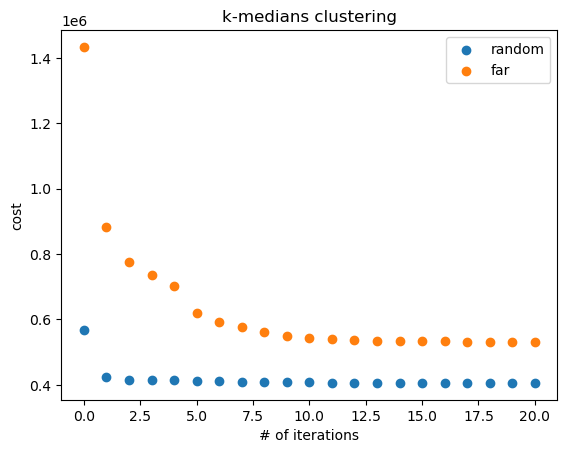

The cost decrease by 0.2809263874711817 after 10 iterations for random initialization
The cost decrease by 0.6213918216351441 after 10 iterations for far initialization


In [25]:
fig, ax = plt.subplots()
ax.scatter(np.arange(0, 21), random_init_k_medians_result[0], label="random")
ax.scatter(np.arange(0, 21), far_init_k_medians_result[0], label="far")
ax.set_xlabel("# of iterations")
ax.set_ylabel("cost")
ax.set_title("k-medians clustering")
ax.legend()
plt.show()

print(f"The cost decrease by {1 - random_init_k_medians_result[0][10] / random_init_k_medians_result[0][0]} after 10 iterations for random initialization")
print(f"The cost decrease by {1 - far_init_k_medians_result[0][10] / far_init_k_medians_result[0][0]} after 10 iterations for far initialization")